In [22]:
import ml_collections
import copy
import numpy as np
import matplotlib.pyplot as plt
import ml_collections
import yaml
from tqdm import tqdm
import os
import torch
import torch.nn as nn
from os import path as pt
import pickle
from torch.utils.data import DataLoader, TensorDataset
from src.baselines.base import BaseTrainer
from src.evaluation.summary import full_evaluation
from src.utils import get_experiment_dir, set_seed, init_weights, save_obj, load_obj
from src.evaluation.scores import compute_auc

In [23]:
with open("./data/ref_data.pkl", "rb") as f:
    loaded_array = pickle.load(f)
training_data = torch.tensor(loaded_array)
print(training_data.shape)
print(training_data[:10,:,1 ])

with open("./data/ref_label.pkl", "rb") as f:
    loaded_array = pickle.load(f)
training_label = torch.tensor(loaded_array)
print(training_label.shape)
print(training_label[:10,:])

torch.Size([1199, 5, 10])
tensor([[0.0172, 0.0155, 0.0146, 0.0145, 0.0146],
        [0.0146, 0.0145, 0.0146, 0.0156, 0.0141],
        [0.0146, 0.0156, 0.0141, 0.0094, 0.0098],
        [0.0141, 0.0094, 0.0098, 0.0145, 0.0165],
        [0.0098, 0.0145, 0.0165, 0.0168, 0.0168],
        [0.0165, 0.0168, 0.0168, 0.0171, 0.0173],
        [0.0168, 0.0171, 0.0173, 0.0164, 0.0157],
        [0.0173, 0.0164, 0.0157, 0.0156, 0.0164],
        [0.0157, 0.0156, 0.0164, 0.0149, 0.0110],
        [0.0164, 0.0149, 0.0110, 0.0141, 0.0138]])
torch.Size([1199, 1])
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


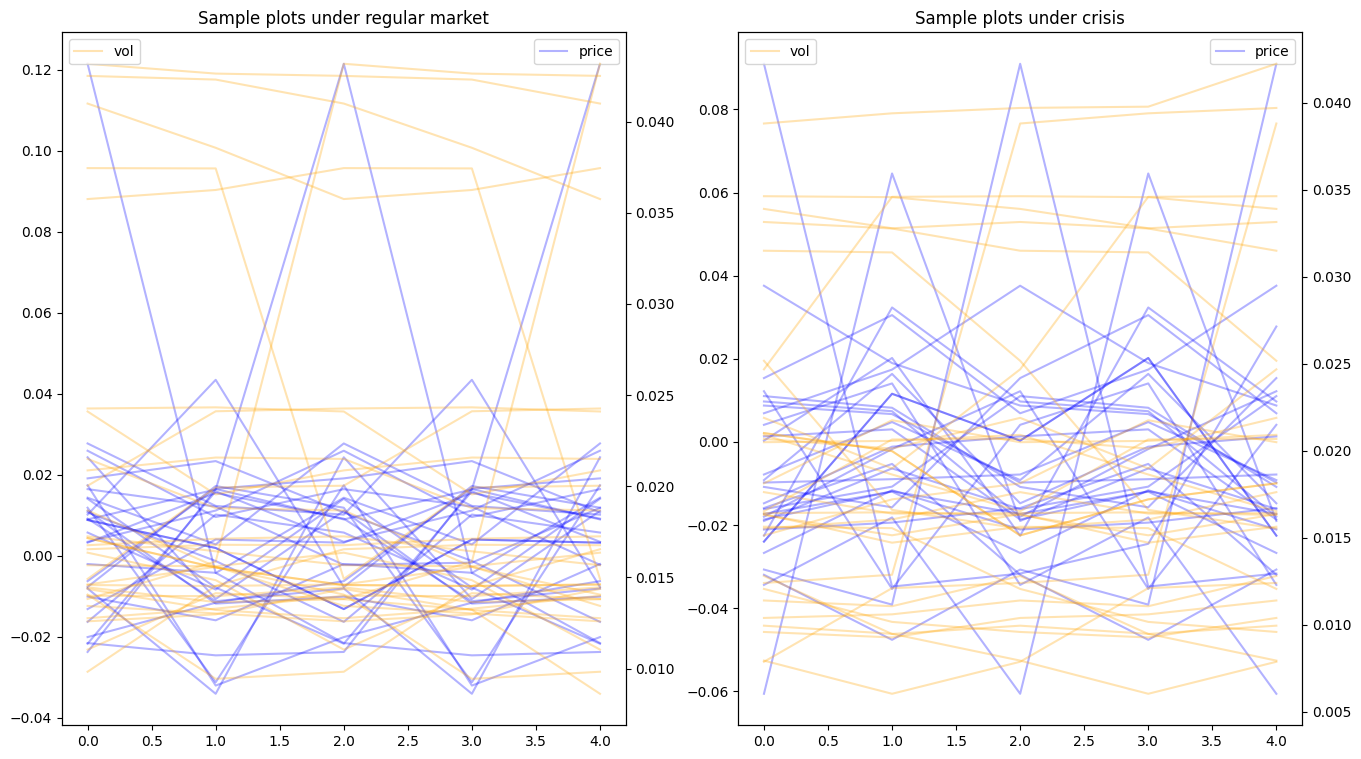

In [25]:
regular_market_data = training_data[(training_label==0).squeeze()]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,9))
ax2 = ax[0].twinx() 
ax[0].plot(regular_market_data[0,:,0], color='b', alpha=0.3, label='price')
ax2.plot(regular_market_data[0,:,1], color='orange', alpha=0.3, label='vol')
for i in range(30):
    ax[0].plot(regular_market_data[i,:,0], color='b', alpha=0.3)
    ax2.plot(regular_market_data[i,:,1], color='orange', alpha=0.3)
ax[0].legend(loc = 1)
ax2.legend(loc = 2)
ax[0].set_title('Sample plots under regular market')

crisis_market_data = training_data[(training_label==1).squeeze()]
ax4 = ax[1].twinx() 
ax[1].plot(crisis_market_data[0,:,0], color='b', alpha=0.3, label='price')
ax4.plot(crisis_market_data[0,:,1], color='orange', alpha=0.3, label='vol')
for i in range(30):
    ax[1].plot(crisis_market_data[i,:,0], color='b', alpha=0.3)
    ax4.plot(crisis_market_data[i,:,1], color='orange', alpha=0.3)
ax[1].legend(loc = 1)
ax4.legend(loc = 2)
ax[1].set_title('Sample plots under crisis')
plt.show()

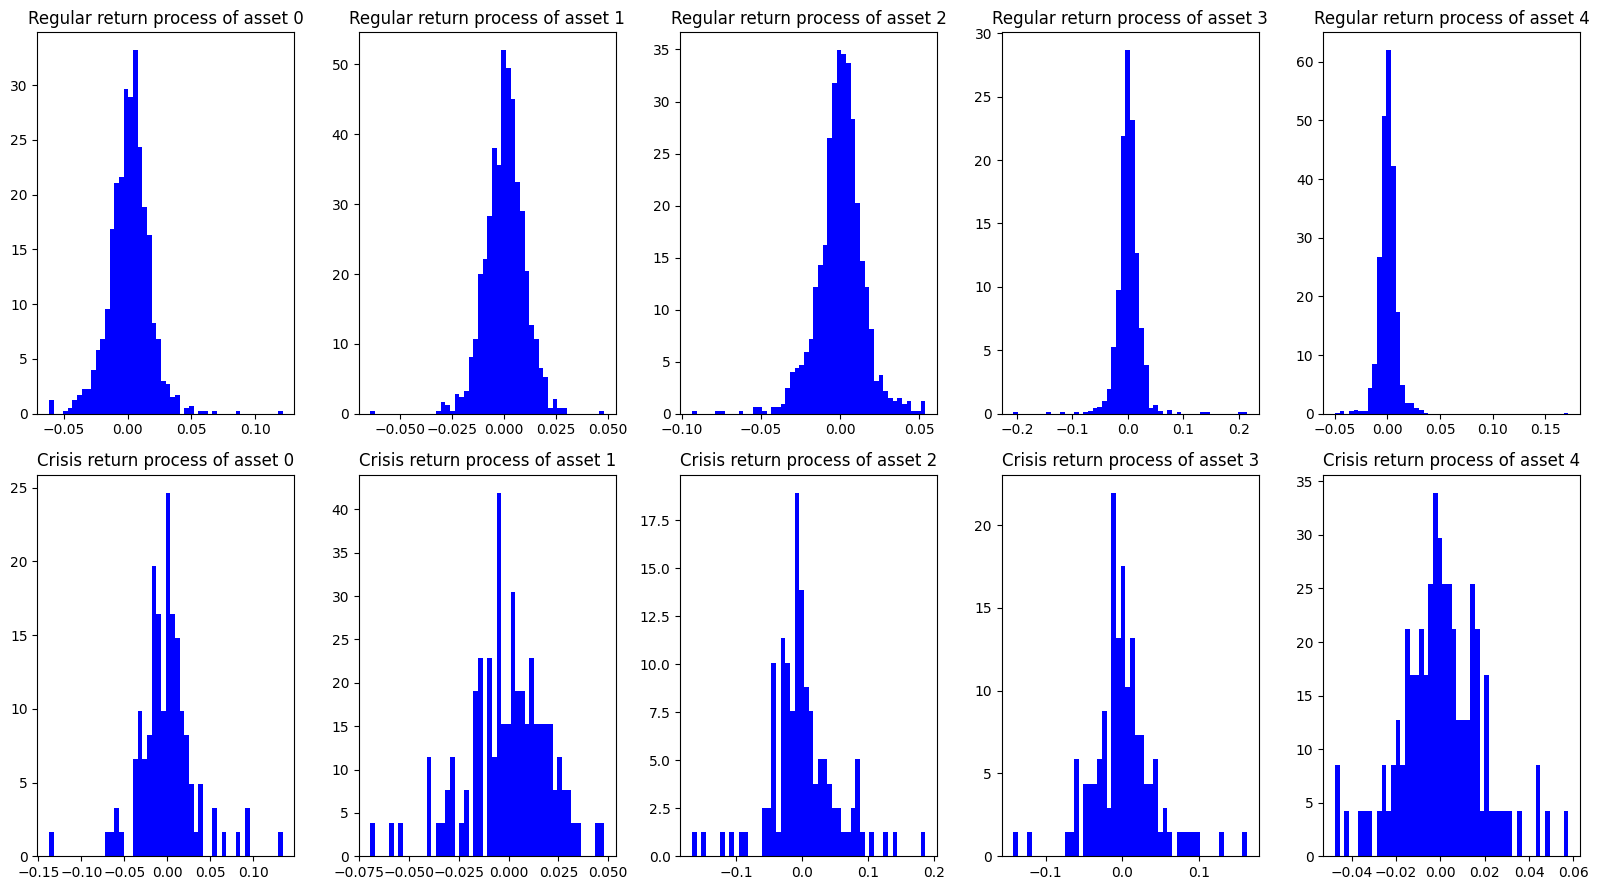

In [26]:
fig, axs = plt.subplots(2, 5, figsize=(16,9))

for i in range(5):
    axs[0, i].hist(regular_market_data[:,-1, 2*i].cpu(), bins = 50, color = 'blue', density = True)
    axs[0, i].set_title('Regular return process of asset {}'.format(i))
#     axs[0, i].set_xlabel('time')

for i in range(5):
    axs[1,i].hist(crisis_market_data[:,-1, 2*i].cpu(), bins = 50, color = 'blue', density = True)
    axs[1,i].set_title('Crisis return process of asset {}'.format(i))
fig.tight_layout()
# plt.title('')
plt.show()

### Generative models for time series generation

In [27]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
    
set_seed(config.seed)

if (config.device ==
        "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:0"}, allow_val_change=True)
else:
    config.update({"device": "cpu"}, allow_val_change=True)
    
class XYDataset(TensorDataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.shape = X.shape

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

### Dataset construction

Since we have limited number of data, we choose to do cross-validation with 5-folds. We illustrate here just 1 division.

In [28]:
perm_idx = torch.randperm(training_data.shape[0])
train_size = int(0.8*training_data.shape[0])

cv_training_data = training_data[perm_idx[:train_size]].to(config.device).to(torch.float)
cv_training_label = training_label[perm_idx[:train_size]].to(config.device).to(torch.float)

cv_validation_data = training_data[perm_idx[train_size:]].to(config.device).to(torch.float)
cv_validation_label = training_label[perm_idx[train_size:]].to(config.device).to(torch.float)

In [29]:
# Load the dataset
training_set = TensorDataset(cv_training_data, cv_training_label)

train_dl = DataLoader(
    training_set,
    batch_size=config.batch_size,
    shuffle=True
)

config.input_dim = cv_training_data[0][0].shape[-1]

### Conditional generative model based on LSTM

Here we construct a conditional generator and discriminator for this task. Both the generator and discriminator takes as input the time series and the label, representing the market situation.

In [30]:
# Sample model based on LSTM
class GeneratorBase(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GeneratorBase, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.input_dim = input_dim
        self.output_dim = output_dim

    def forward(self, batch_size: int, n_lags: int, device: str):
        """ Implement here generation scheme. """
        # ...
        pass


class ConditionalLSTMGenerator(GeneratorBase):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int, n_layers: int):
        super(ConditionalLSTMGenerator, self).__init__(input_dim, output_dim)
        # LSTM
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                           num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim, bias=True)
        self.linear.apply(init_weights)


    def forward(self, batch_size: int, condition: torch.Tensor, n_lags: int, device: str) -> torch.Tensor:
        z = (0.1 * torch.randn(batch_size, n_lags,
                               self.input_dim - condition.shape[-1])).to(device)  # cumsum(1)
        z[:, 0, :] *= 0  # first point is fixed
        z = z.cumsum(1)
        z = torch.cat([z, condition.unsqueeze(1).repeat((1, n_lags, 1))], dim=2)

        h0 = torch.zeros(self.rnn.num_layers, batch_size,
                         self.rnn.hidden_size).to(device)

        c0 = torch.zeros_like(h0)
        h1, _ = self.rnn(z, (h0, c0))
        x = self.linear(h1)

        assert x.shape[1] == n_lags
        return x
    
class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, n_layers: int, out_dim=1):
        super(LSTMDiscriminator, self).__init__()
        self.input_dim = input_dim
        self.lstm = nn.LSTM(input_size=input_dim+1,
                            hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)

    def forward(self, x: torch.Tensor, condition: torch.Tensor) -> torch.Tensor:
        z = torch.cat([x, condition.unsqueeze(1).repeat((1, x.shape[1], 1))], dim=2)
        h = self.lstm(z)[0][:, -1:]
        x = self.linear(h)
        return x  

### Define the training algorithm

In [31]:
class RCGANTrainer(BaseTrainer):
    def __init__(self, D, G, train_dl, config,
                 **kwargs):
        super(RCGANTrainer, self).__init__(
            G=G,
            G_optimizer=torch.optim.Adam(
                G.parameters(), lr=config.lr_G, betas=(0, 0.9)),
            **kwargs
        )

        self.config = config
        self.D_steps_per_G_step = config.D_steps_per_G_step
        self.D = D
        self.D_optimizer = torch.optim.Adam(
            D.parameters(), lr=config.lr_D, betas=(0, 0.9))  # Using TTUR

        self.train_dl = train_dl
        self.reg_param = 0
        self.losses_history

    def fit(self, device):
        self.G.to(device)
        self.D.to(device)

        for i in tqdm(range(self.n_gradient_steps)):
            self.step(device, i)

    def step(self, device, step):
        for i in range(self.D_steps_per_G_step):
            # generate x_fake
            condition = None
            x_real_batch, label_batch = next(iter(self.train_dl))
            x_real_batch = x_real_batch.to(device)
            label_batch = label_batch.to(device)
            with torch.no_grad():
                x_fake = self.G(batch_size=self.batch_size,
                                n_lags=self.config.n_lags, condition=label_batch, device=device)

            D_loss_real, D_loss_fake = self.D_trainstep(
                x_fake, x_real_batch, label_batch)
            if i == 0:
                self.losses_history['D_loss_fake'].append(D_loss_fake)
                self.losses_history['D_loss_real'].append(D_loss_real)
                self.losses_history['D_loss'].append(D_loss_fake + D_loss_real)
        G_loss = self.G_trainstep(label_batch, device, step)

    def G_trainstep(self, condition, device, step):
        x_fake = self.G(batch_size=self.batch_size,
                        n_lags=self.config.n_lags, condition=condition, device=device)
        self.toggle_grad(self.G, True)
        self.G.train()
        self.G_optimizer.zero_grad()
        d_fake = self.D(x_fake, condition)
        self.D.train()
        G_loss = self.compute_loss(d_fake, 1.)
        G_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.G.parameters(), 10)
        self.losses_history['G_loss'].append(G_loss)
        self.G_optimizer.step()

        return G_loss.item()

    def D_trainstep(self, x_fake, x_real, condition):
        self.toggle_grad(self.D, True)
        self.D.train()
        self.D_optimizer.zero_grad()

        # On real data
        x_real.requires_grad_()
        d_real = self.D(x_real,condition)
        dloss_real = self.compute_loss(d_real, 1.)

        # On fake data
        x_fake.requires_grad_()
        d_fake = self.D(x_fake,condition)
        dloss_fake = self.compute_loss(d_fake, 0.)

        # Compute regularizer on fake / real
        dloss = dloss_fake + dloss_real

        dloss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.D.parameters(), 10)
        # Step discriminator params
        self.D_optimizer.step()

        # Toggle gradient to False
        self.toggle_grad(self.D, False)

        return dloss_real.item(), dloss_fake.item()

    def compute_loss(self, d_out, target):
        targets = d_out.new_full(size=d_out.size(), fill_value=target)
        loss = torch.nn.BCELoss()(torch.nn.Sigmoid()(d_out), targets)
        return loss

    def save_model_dict(self):
        save_obj(self.G.state_dict(), pt.join(
            self.config.exp_dir, 'generator_state_dict.pt'))


### Initialize the generator, discriminator and the trainer

In [32]:
D_out_dim = 1
return_seq = False

generator = ConditionalLSTMGenerator(
    input_dim=config.G_input_dim, hidden_dim=config.G_hidden_dim, output_dim=config.input_dim,
    n_layers=config.G_num_layers)
discriminator = LSTMDiscriminator(
    input_dim=config.input_dim, hidden_dim=config.D_hidden_dim, out_dim=D_out_dim, n_layers=config.D_num_layers)
    # print('GENERATOR:', generator)
    # print('DISCRIMINATOR:', discriminator)

trainer = RCGANTrainer(G=generator, D=discriminator,
                    train_dl=train_dl, batch_size=config.batch_size, n_gradient_steps=config.steps,
                    config=config)


### Model training and saving

In [33]:
# Model training
trainer.fit(config.device)
save_obj(trainer.G.state_dict(), './sample_submission_bundle/model_dict.pkl')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.99it/s]


0

### Synthetic data generation

In [34]:
generator = ConditionalLSTMGenerator(
    input_dim=config.G_input_dim, hidden_dim=config.G_hidden_dim, output_dim=config.input_dim,
    n_layers=config.G_num_layers).to(config.device)

g_state_dict = load_obj('./sample_submission_bundle/model_dict.pkl')

generator.load_state_dict(g_state_dict)

generator.eval()


with torch.no_grad():
    # Generate fake data under the regular market situation
    condition = torch.zeros([200,0]).to(config.device)
    regular_fake_data = generator(batch_size=200,
                        n_lags=config.n_lags, condition=condition, device=config.device)
    
    # Generate fake data under the crisis
    condition = torch.ones([200,1]).to(config.device)
    crisis_fake_data = generator(batch_size=200,
                        n_lags=config.n_lags, condition=condition, device=config.device)
    
# Save the data
save_obj(regular_fake_data.cpu().numpy(), './sample_submission_bundle/fake_regular.pkl')
save_obj(crisis_fake_data.cpu().numpy(), './sample_submission_bundle/fake_crisis.pkl')

0

### Model evaluation

Generic time series test metrics, the final score of each test metrics will be a weighted sum between the performance on regular generation and crisis generation

In [35]:
config_dir = 'src/evaluation/config.yaml'
with open(config_dir) as file:
    eval_config = ml_collections.ConfigDict(yaml.safe_load(file))

regular_cv_validation_data = cv_validation_data[(cv_validation_label==0).squeeze()]
crisis_cv_validation_data = cv_validation_data[(cv_validation_label==1).squeeze()]

res_dict_regular = full_evaluation(regular_fake_data, regular_cv_validation_data, eval_config)
for k, v in res_dict_regular.items():
    print(k, v)
    
res_dict_crisis = full_evaluation(crisis_fake_data, crisis_cv_validation_data, eval_config)
for k, v in res_dict_regular.items():
    print(k, v)

---- evaluation metric = hist_loss in group = stylized_fact_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.12it/s]


---- evaluation metric = acf_loss in group = stylized_fact_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 93.83it/s]


---- evaluation metric = cov_loss in group = stylized_fact_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 83.30it/s]


---- evaluation metric = cross_corr in group = stylized_fact_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 62.65it/s]


 No metrics enabled in group = implicit_scores
 No metrics enabled in group = sig_scores
 No metrics enabled in group = permutation_test
 No metrics enabled in group = distance_based_metrics
---- evaluation metric = var in group = tail_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 67.70it/s]


---- evaluation metric = es in group = tail_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 82.66it/s]


hist_loss_mean 24.82125
hist_loss_std 0.90875643
acf_loss_mean 0.43369475
acf_loss_std 0.014890544
cov_loss_mean 1.8524894e-05
cov_loss_std 2.233752e-06
cross_corr_mean 29.904888
cross_corr_std 0.4156694
var_mean 0.026317377
var_std 0.0033867666
es_mean 0.023741778
es_std 0.00058297353
---- evaluation metric = hist_loss in group = stylized_fact_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 54.25it/s]


---- evaluation metric = acf_loss in group = stylized_fact_scores ----


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 138.48it/s]


---- evaluation metric = cov_loss in group = stylized_fact_scores ----


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 127.07it/s]


---- evaluation metric = cross_corr in group = stylized_fact_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 93.59it/s]


 No metrics enabled in group = implicit_scores
 No metrics enabled in group = sig_scores
 No metrics enabled in group = permutation_test
 No metrics enabled in group = distance_based_metrics
---- evaluation metric = var in group = tail_scores ----


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 104.60it/s]


---- evaluation metric = es in group = tail_scores ----


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 95.13it/s]

hist_loss_mean 24.82125
hist_loss_std 0.90875643
acf_loss_mean 0.43369475
acf_loss_std 0.014890544
cov_loss_mean 1.8524894e-05
cov_loss_std 2.233752e-06
cross_corr_mean 29.904888
cross_corr_std 0.4156694
var_mean 0.026317377
var_std 0.0033867666
es_mean 0.023741778
es_std 0.00058297353


We also test the utility of generated time series to alliviate the imbalanced issue. We augment the original dataset by fake time series during the crisis period, and we train a classifier that distinguishes the crisis period from regular period. Once trained, we test the performance of the model on the real dataset, and the AUC is computed.

In [36]:
regular_cv_training_data = cv_training_data[(cv_training_label==0).squeeze()]
crisis_cv_training_data = cv_training_data[(cv_training_label==1).squeeze()]
auc = compute_auc(crisis_cv_training_data, crisis_fake_data, regular_cv_training_data, regular_fake_data, eval_config)
print(auc)

0.5
